In [2]:
import pickle
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch
import torch.nn as nn
import torch.optim as optim
from focal_loss.focal_loss import FocalLoss
from torch.utils.data import Dataset, DataLoader, TensorDataset, WeightedRandomSampler, RandomSampler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
#from autoencoder_utils import *
from joint_utils import *

In [3]:
# Filepath to embeddings
fname = '/mnt/mimic/data/HAIM/mimic_extras/embeddings.csv'

tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")
phi3 = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-4k-instruct", 
    device_map="cuda", 
    torch_dtype="auto", 
    trust_remote_code=True, 
)
phi3.eval()

# Read data & extract labels and features
df = pd.read_csv(fname)


# Load train/val sets and create data loaders
batch_size = 32

Data = DataSplit(df)
Data.split_data('all')
X, V = Data.get_data()

torch.manual_seed(42)


Data.y_train = Data.y_train.apply(lambda lst: [2 if x == -1 else x for x in lst])
Data.y_val = Data.y_val.apply(lambda lst: [2 if x == -1 else x for x in lst])

train_set = CustomDataset(X.values.tolist(), Data.y_train.tolist())
val_set = CustomDataset(V.values.tolist(), Data.y_val.tolist())

transposed_Y = list(map(list, zip(*Data.y_train.tolist())))

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=5)
val_loader = DataLoader(val_set, batch_size=batch_size, num_workers=5)

tokenizer_config.json:   0%|          | 0.00/3.17k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

configuration_phi3.py:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-4k-instruct:
- configuration_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi3.py:   0%|          | 0.00/73.8k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-4k-instruct:
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
`flash-attention` package not found, consider installing for better performance: No module named 'flash_attn'.
Current `flash-attenton` does not support `window_size`. Either upgrade or use `attn_implementation='eager'`.


model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

/home/liv/multimodal_healthcare/joint_utils.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_death_small48['y'] = 1
/home/liv/multimodal_healthcare/joint_utils.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alive_big48['y'] = 0
/home/liv/multimodal_healthcare/joint_utils.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

In [7]:
# Setting model and hyperparameters
vd_model = torch.load('results/final_models/phi3_joint/vd.pth').to('cuda')
vmd_model = torch.load('results/final_models/phi3_joint/vmd.pth').to('cuda')

ts_pe_model = torch.load('results/final_models/phi3_joint/ts_pe.pth').to('cuda')
ts_ce_model = torch.load('results/final_models/phi3_joint/ts_ce.pth').to('cuda')
ts_le_model = torch.load('results/final_models/phi3_joint/ts_le.pth').to('cuda')

n_rad_model = torch.load('results/final_models/phi3_joint/n_rad.pth').to('cuda')
models = [vd_model, vmd_model, ts_pe_model, ts_ce_model, ts_le_model, n_rad_model]

In [8]:
def output_to_label(logits, labels):

    probs_tensor_pos = F.sigmoid(logits)

    pred = torch.round(probs_tensor_pos)

    probs_tensor_neg = 1-probs_tensor_pos

    prob = torch.stack((probs_tensor_neg, probs_tensor_pos), dim=1)


    return prob, pred, labels

In [15]:
def predict(models, val_loader, phi):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    per_class_probs = [[] for _ in range(12)]
    per_class_preds = [[] for _ in range(12)]
    per_class_labels = [[] for _ in range(12)]

    for model in models:
        model.eval()
    with torch.no_grad():
        for batch_index, (x, y) in enumerate(val_loader, 1):
            inputs, labels = x, y.to(device)

            vd_inputs = x['vd'].to(device)
            vmd_inputs = x['vmd'].to(device)
            ts_pe_inputs = x['ts_pe'].to(device)
            ts_ce_inputs = x['ts_ce'].to(device)
            ts_le_inputs = x['ts_le'].to(device)
            n_rad_inputs = x['n_rad'].to(device)

            encoded_vd = models[0].encoder(vd_inputs)
            encoded_vmd = models[1].encoder(vmd_inputs)
            encoded_ts_pe = models[2].encoder(ts_pe_inputs)
            encoded_ts_ce = models[3].encoder(ts_ce_inputs)
            encoded_ts_le = models[4].encoder(ts_le_inputs)
            encoded_n_rad = models[5].encoder(n_rad_inputs)

            decoded_vd = models[0].decoder(encoded_vd)
            decoded_vmd = models[1].decoder(encoded_vmd)
            decoded_ts_pe = models[2].decoder(encoded_ts_pe)
            decoded_ts_ce = models[3].decoder(encoded_ts_ce)
            decoded_ts_le = models[4].decoder(encoded_ts_le)
            decoded_n_rad = models[5].decoder(encoded_n_rad)

            inputs = [vd_inputs, vmd_inputs, ts_pe_inputs, ts_ce_inputs, ts_le_inputs, n_rad_inputs]
            decoded = [decoded_vd, decoded_vmd, decoded_ts_pe, decoded_ts_ce, decoded_ts_le, decoded_n_rad]

            concat_emb = torch.cat((encoded_vd.view(-1,1,3072).to(torch.bfloat16), encoded_vmd.view(-1,1,3072).to(torch.bfloat16), 
                                encoded_ts_pe.view(-1,1,3072).to(torch.bfloat16), encoded_ts_ce.view(-1,1,3072).to(torch.bfloat16), 
                                encoded_ts_le.view(-1,1,3072).to(torch.bfloat16), encoded_n_rad.view(-1,1,3072).to(torch.bfloat16)),
                                  dim=1).to(device)

            logits = custom_output(concat_emb, phi)

            probabilities, hard_preds, labels = output_to_label(logits, labels)


            for i in range(probabilities.size(2)):
                class_prob = probabilities[:, :, i]  # Select probabilities for class i
                per_class_probs[i].append(probabilities[:, :, i])
                per_class_preds[i].append(hard_preds[:, i])
                per_class_labels[i].append(labels[:, i])


    return per_class_preds, per_class_labels, per_class_probs

In [16]:
per_class_preds, per_class_labels, per_class_probs = predict(models, val_loader, phi3)

In [17]:
f1_scores = []
auc_scores = []
precisions = []
recalls = []
accuracies = []
matrices = []
fpr_tpr = []
roc_aucs = []

for i,class_preds in enumerate(per_class_preds):
    preds = []
    preds = [t.cpu().numpy() for t in class_preds]
    preds = np.concatenate(preds)
    labels = []
    labels = [t.cpu().numpy() for t in per_class_labels[i]]
    labels = np.concatenate(labels)
    stuff = len(per_class_probs[i][0])
    probs = []
    probs = [t.cpu().numpy() for t in per_class_probs[i]]
    probs = np.concatenate(probs, axis=0)
    mask = ~np.isnan(labels) & (labels != 2)
    masked_labels = labels[mask]
    masked_preds = preds[mask]
    masked_probs = probs[mask]
    positive_probs = masked_probs[:, 1]
    f1_scores.append(metrics.f1_score(masked_labels, masked_preds, average='macro'))
    auc_scores.append(metrics.roc_auc_score(masked_labels, positive_probs))
    precisions.append(metrics.precision_score(masked_labels, masked_preds))
    recalls.append(metrics.recall_score(masked_labels, masked_preds))
    accuracies.append(metrics.accuracy_score(masked_labels, masked_preds))
    matrices.append(metrics.confusion_matrix(masked_labels, masked_preds))
    fpr, tpr, thresholds = metrics.roc_curve(masked_labels, positive_probs)
    fpr_tpr.append((fpr,tpr))
    roc_aucs.append(metrics.auc(fpr, tpr))

Class: Fracture
F1 score: 0.5601175047520304
AUC score: 0.7181188264779595
Precision: 0.946875
Recall: 0.9380804953560371
Accuracy: 0.8924418604651163



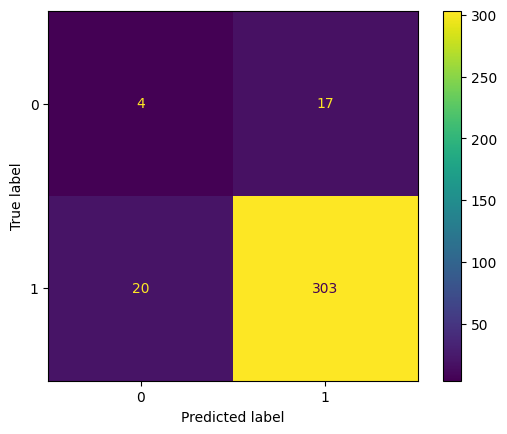

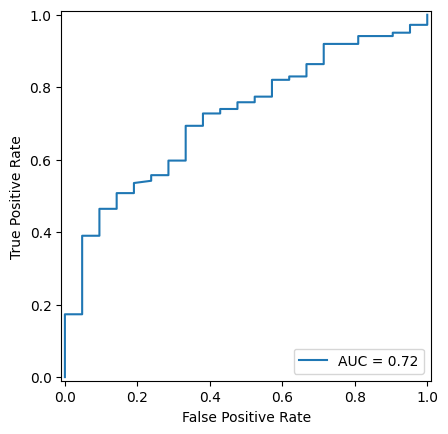

In [18]:
print('Class: Fracture')

print(f'F1 score: {f1_scores[0]}\n'
        f'AUC score: {auc_scores[0]}\n'
        f'Precision: {precisions[0]}\n'
        f'Recall: {recalls[0]}\n'
        f'Accuracy: {accuracies[0]}\n')

matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=matrices[0])
matrix.plot()

fpr, tpr = fpr_tpr[0]
roc_curve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_aucs[0])
roc_curve.plot()

Class: Lung Lesion
F1 score: 0.4841688654353562
AUC score: 0.6669504995458675
Precision: 0.9386189258312021
Recall: 1.0
Accuracy: 0.9386189258312021



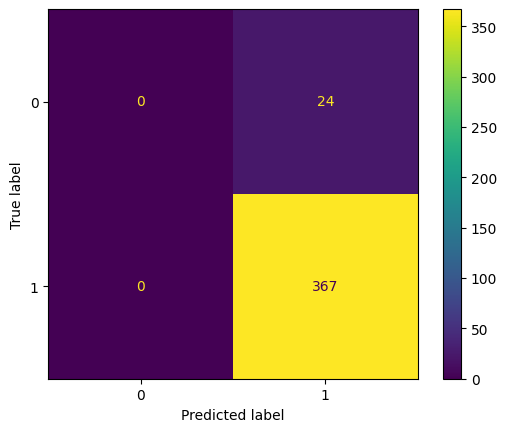

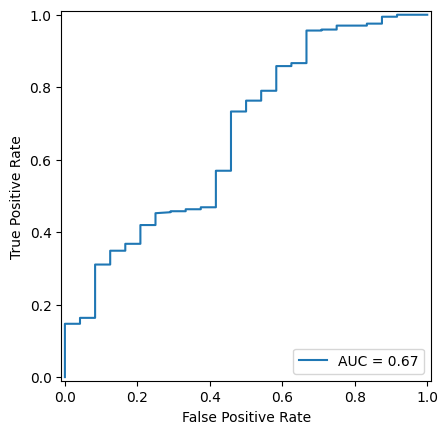

In [19]:
print('Class: Lung Lesion')
print(f'F1 score: {f1_scores[1]}\n'
        f'AUC score: {auc_scores[1]}\n'
        f'Precision: {precisions[1]}\n'
        f'Recall: {recalls[1]}\n'
        f'Accuracy: {accuracies[1]}\n')

matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=matrices[1])
matrix.plot()

fpr, tpr = fpr_tpr[1]
roc_curve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_aucs[1])
roc_curve.plot()

Class: Enlarged Cardiomediastinum
F1 score: 0.5339697299221434
AUC score: 0.7908775270740762
Precision: 0.7595419847328244
Recall: 0.9875930521091811
Accuracy: 0.7602196461256864



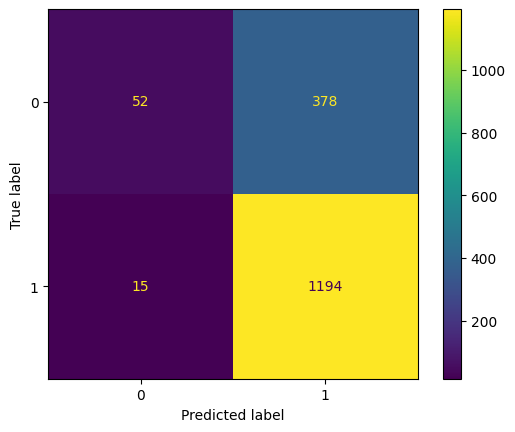

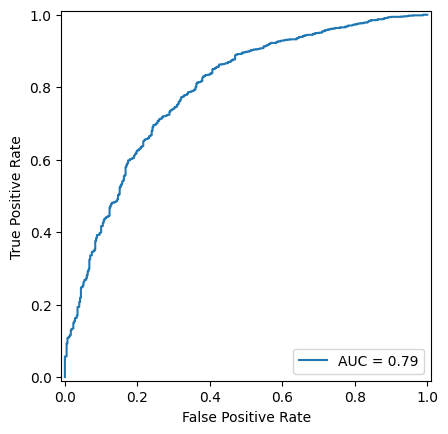

In [20]:
print('Class: Enlarged Cardiomediastinum')
print(f'F1 score: {f1_scores[2]}\n'
        f'AUC score: {auc_scores[2]}\n'
        f'Precision: {precisions[2]}\n'
        f'Recall: {recalls[2]}\n'
        f'Accuracy: {accuracies[2]}\n')

matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=matrices[2])
matrix.plot()

fpr, tpr = fpr_tpr[2]
roc_curve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_aucs[2])
roc_curve.plot()

Class: Consolidation
F1 score: 0.6066009656723328
AUC score: 0.8664671076745849
Precision: 0.8602409638554217
Recall: 0.9907493061979649
Accuracy: 0.8576952822892498



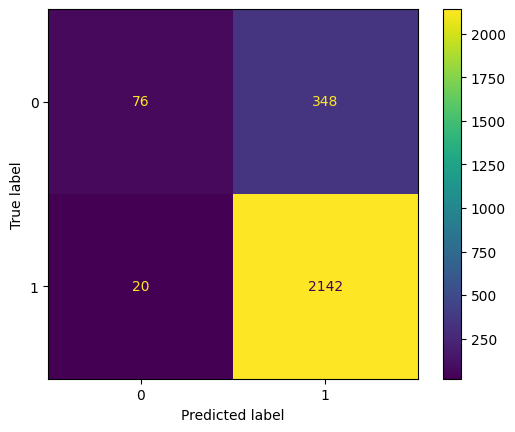

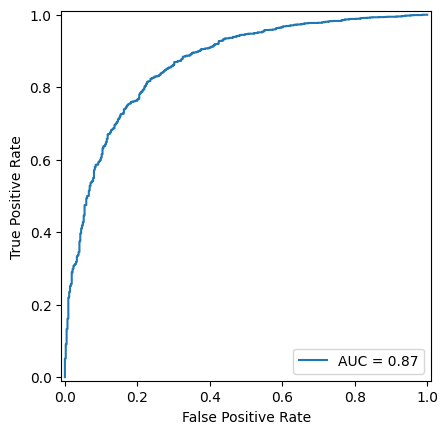

In [21]:
print('Class: Consolidation')
print(f'F1 score: {f1_scores[3]}\n'
        f'AUC score: {auc_scores[3]}\n'
        f'Precision: {precisions[3]}\n'
        f'Recall: {recalls[3]}\n'
        f'Accuracy: {accuracies[3]}\n')

matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=matrices[3])
matrix.plot()

fpr, tpr = fpr_tpr[3]
roc_curve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_aucs[3])
roc_curve.plot()

Class: Pneumonia
F1 score: 0.507911187911188
AUC score: 0.8055793673981382
Precision: 0.5905557155197236
Recall: 0.9874819451131439
Accuracy: 0.6165254237288136



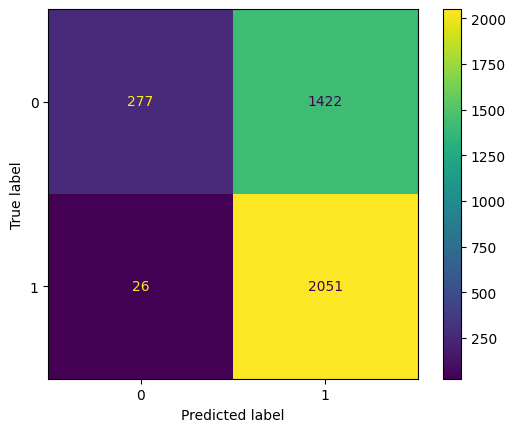

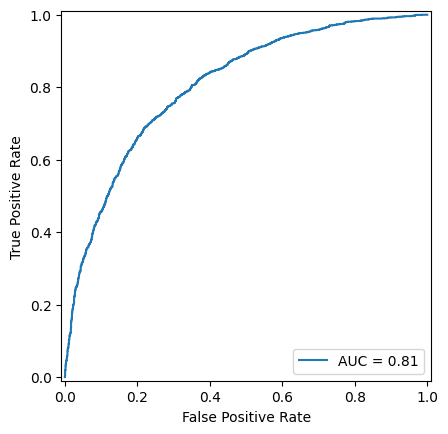

In [22]:
print('Class: Pneumonia')
print(f'F1 score: {f1_scores[4]}\n'
        f'AUC score: {auc_scores[4]}\n'
        f'Precision: {precisions[4]}\n'
        f'Recall: {recalls[4]}\n'
        f'Accuracy: {accuracies[4]}\n')

matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=matrices[4])
matrix.plot()

fpr, tpr = fpr_tpr[4]
roc_curve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_aucs[4])
roc_curve.plot()

Class: Atelectasis
F1 score: 0.4994146112306242
AUC score: 0.7398988546978802
Precision: 0.9760898282694848
Recall: 1.0
Accuracy: 0.9760929863954564



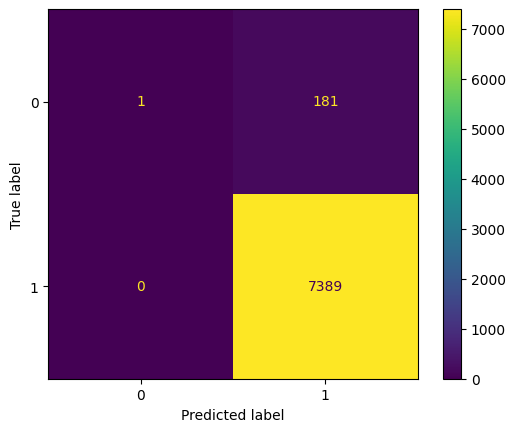

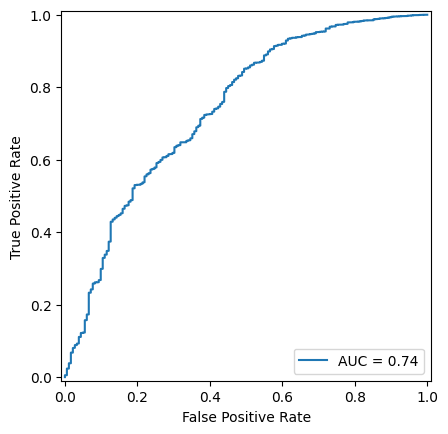

In [23]:
print('Class: Atelectasis')
print(f'F1 score: {f1_scores[5]}\n'
        f'AUC score: {auc_scores[5]}\n'
        f'Precision: {precisions[5]}\n'
        f'Recall: {recalls[5]}\n'
        f'Accuracy: {accuracies[5]}\n')

matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=matrices[5])
matrix.plot()

fpr, tpr = fpr_tpr[5]
roc_curve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_aucs[5])
roc_curve.plot()

Class: Lung Opacity
F1 score: 0.4981627540491042
AUC score: 0.7860055116937287
Precision: 0.9643138283914983
Recall: 1.0
Accuracy: 0.9643231899265478



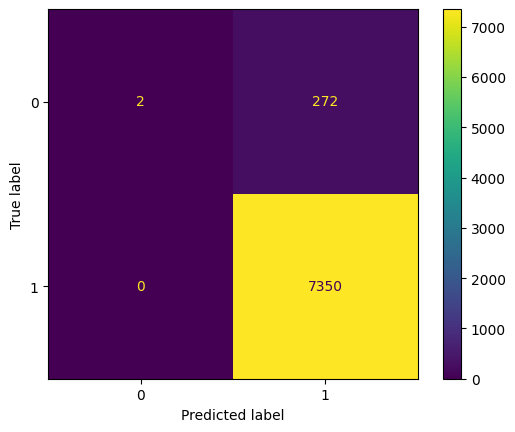

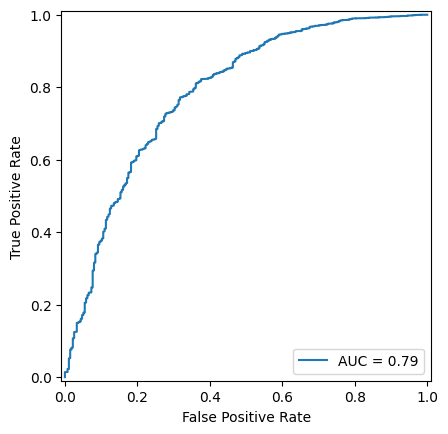

In [24]:
print('Class: Lung Opacity')
print(f'F1 score: {f1_scores[6]}\n'
        f'AUC score: {auc_scores[6]}\n'
        f'Precision: {precisions[6]}\n'
        f'Recall: {recalls[6]}\n'
        f'Accuracy: {accuracies[6]}\n')

matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=matrices[6])
matrix.plot()

fpr, tpr = fpr_tpr[6]
roc_curve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_aucs[6])
roc_curve.plot()

Class: Pneumothorax
F1 score: 0.6007716745023215
AUC score: 0.7503783209916872
Precision: 0.3124083308888237
Recall: 0.7052980132450332
Accuracy: 0.6712635549269212



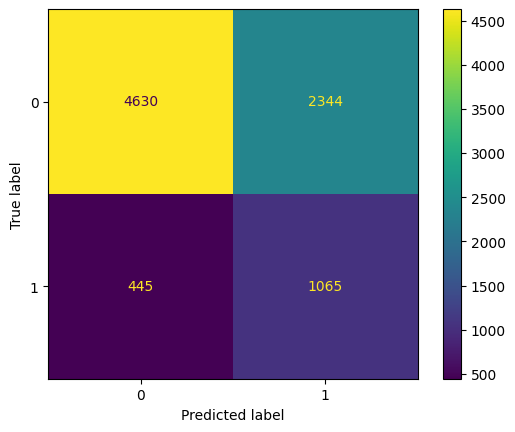

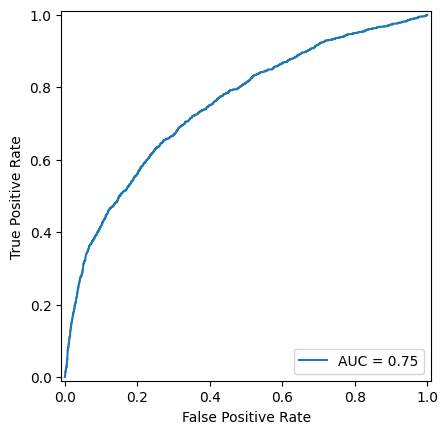

In [25]:
print('Class: Pneumothorax')
print(f'F1 score: {f1_scores[7]}\n'
        f'AUC score: {auc_scores[7]}\n'
        f'Precision: {precisions[7]}\n'
        f'Recall: {recalls[7]}\n'
        f'Accuracy: {accuracies[7]}\n')

matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=matrices[7])
matrix.plot()

fpr, tpr = fpr_tpr[7]
roc_curve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_aucs[7])
roc_curve.plot()

Class: Edema
F1 score: 0.5517108868717351
AUC score: 0.8538108114281298
Precision: 0.6725968831885257
Recall: 0.9922685656154628
Accuracy: 0.6911651728553136



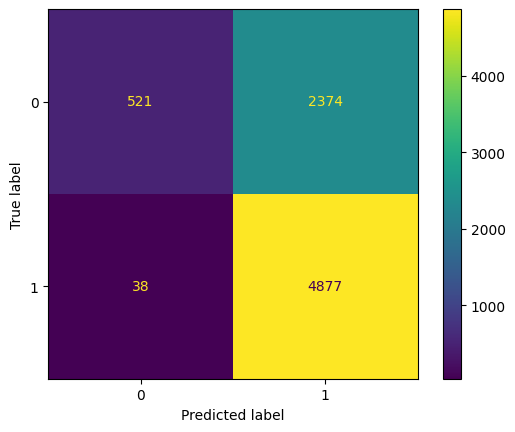

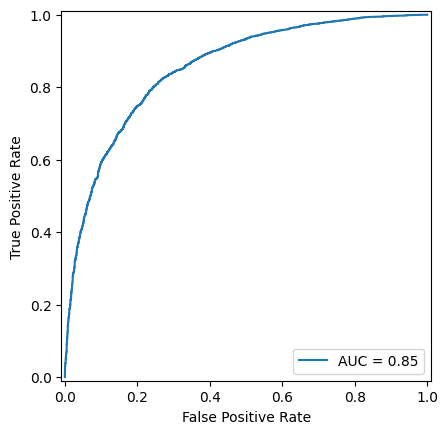

In [26]:
print('Class: Edema')
print(f'F1 score: {f1_scores[8]}\n'
        f'AUC score: {auc_scores[8]}\n'
        f'Precision: {precisions[8]}\n'
        f'Recall: {recalls[8]}\n'
        f'Accuracy: {accuracies[8]}\n')

matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=matrices[8])
matrix.plot()

fpr, tpr = fpr_tpr[8]
roc_curve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_aucs[8])
roc_curve.plot()

Class: Cardiomegaly
F1 score: 0.6146200439119509
AUC score: 0.8561743687399352
Precision: 0.8406345332519829
Recall: 0.9868213722962327
Accuracy: 0.8377813877929914



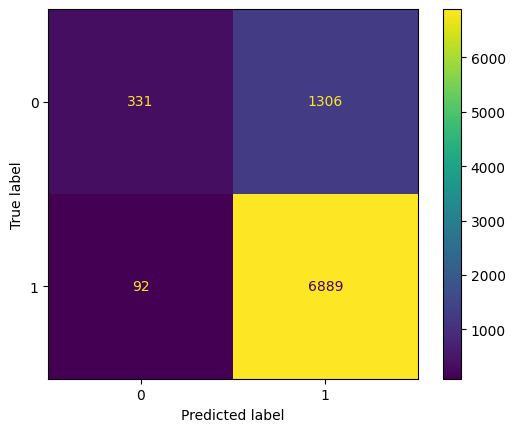

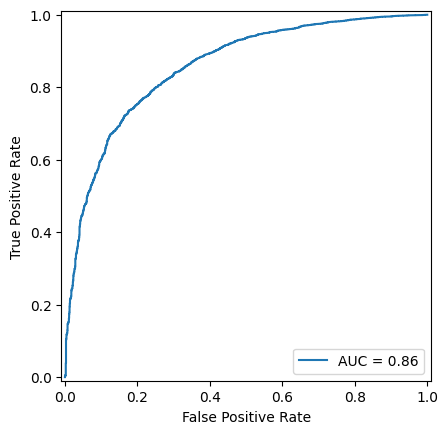

In [27]:
print('Class: Cardiomegaly')
print(f'F1 score: {f1_scores[9]}\n'
        f'AUC score: {auc_scores[9]}\n'
        f'Precision: {precisions[9]}\n'
        f'Recall: {recalls[9]}\n'
        f'Accuracy: {accuracies[9]}\n')

matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=matrices[9])
matrix.plot()

fpr, tpr = fpr_tpr[9]
roc_curve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_aucs[9])
roc_curve.plot()

Class: Length-of-Stay
F1 score: 0.5588681823492617
AUC score: 0.7664239472725396
Precision: 0.19257351944707954
Recall: 0.6828447861604997
Accuracy: 0.7102832377533599



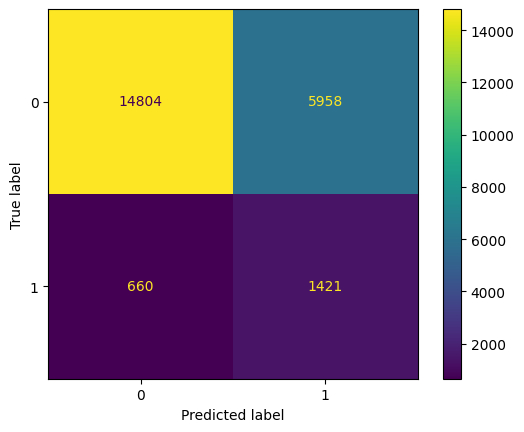

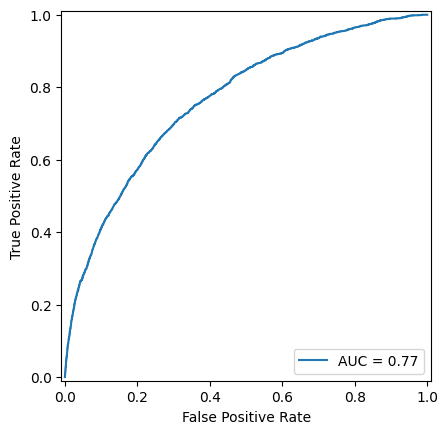

In [28]:
print('Class: Length-of-Stay')
print(f'F1 score: {f1_scores[10]}\n'
        f'AUC score: {auc_scores[10]}\n'
        f'Precision: {precisions[10]}\n'
        f'Recall: {recalls[10]}\n'
        f'Accuracy: {accuracies[10]}\n')

matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=matrices[10])
matrix.plot()

fpr, tpr = fpr_tpr[10]
roc_curve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_aucs[10])
roc_curve.plot()

Class: 48-hour Mortality
F1 score: 0.5489702910968124
AUC score: 0.7735837629841065
Precision: 0.09073170731707317
Recall: 0.39658848614072495
Accuracy: 0.9060105940550716



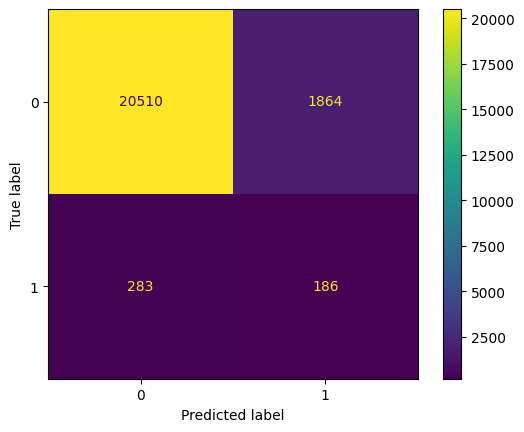

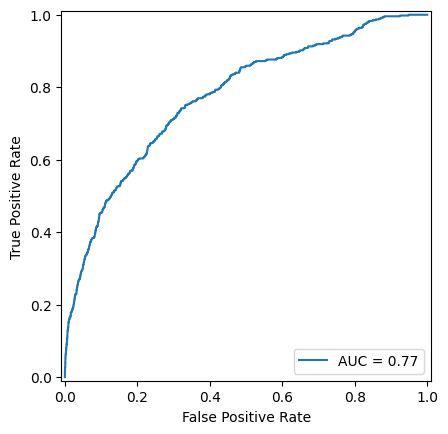

In [29]:
print('Class: 48-hour Mortality')
print(f'F1 score: {f1_scores[11]}\n'
        f'AUC score: {auc_scores[11]}\n'
        f'Precision: {precisions[11]}\n'
        f'Recall: {recalls[11]}\n'
        f'Accuracy: {accuracies[11]}\n')

matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=matrices[11])
matrix.plot()

fpr, tpr = fpr_tpr[11]
roc_curve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_aucs[11])
roc_curve.plot()